# 1.SetUp and Load data


## 1.1 Install and setup dependencies

In [1]:
!pip list

Package                  Version
------------------------ -----------
absl-py                  0.15.0
aiohttp                  3.8.1
aiosignal                1.2.0
anyio                    3.6.2
argon2-cffi              21.3.0
argon2-cffi-bindings     21.2.0
asttokens                2.0.8
astunparse               1.6.3
async-generator          1.10
async-timeout            4.0.2
attrs                    22.1.0
Babel                    2.10.3
backcall                 0.2.0
beautifulsoup4           4.11.1
bleach                   5.0.1
blinker                  1.4
brotlipy                 0.7.0
cachetools               4.2.2
certifi                  2022.9.24
cffi                     1.15.1
charset-normalizer       2.0.4
click                    8.0.4
cryptography             37.0.1
cycler                   0.11.0
debugpy                  1.6.3
decorator                5.1.1
defusedxml               0.7.1
dill                     0.3.4
entrypoints              0.4
exceptiongroup         

In [2]:
import tensorflow as tf
import os

In [3]:
os.listdir('data')


['disgust', 'angry', 'fear', 'neutral', 'sad', 'happy', 'surprise']

In [4]:
# dataset 
# https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset

### Remove doddy images

In [5]:
import cv2
import imghdr

In [6]:
data_dir = 'data'

In [7]:
img_exts = ['jpeg', 'jpg', 'bmp', 'png', ]
img_exts

['jpeg', 'jpg', 'bmp', 'png']

In [8]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        img_path = os.path.join(data_dir, image_class, image)
        try:
            cv2.imread(img_path)
            tip = imghdr.what(img_path)
            if tip not in img_exts:
                print('Image is not in ext list {}'.format(img_path))
                os.remove(img_path)
                
        except Exception as e:
            print('Issue with image {}'.format(img_path))

# Load Data

In [9]:
tf.data.Dataset

tensorflow.python.data.ops.dataset_ops.DatasetV2

In [10]:
import numpy as np
from matplotlib import pyplot as plt

In [11]:
data = tf.keras.utils.image_dataset_from_directory('data')
data

Found 28821 files belonging to 7 classes.


2022-11-01 13:31:51.927484: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [12]:
data_iterator = data.as_numpy_iterator()

In [13]:
batch = data_iterator.next()

In [14]:
batch[0].shape

(32, 256, 256, 3)

In [15]:
batch[1]

array([2, 2, 3, 4, 0, 2, 6, 0, 0, 2, 4, 4, 0, 4, 2, 2, 5, 5, 3, 4, 6, 3,
       4, 4, 4, 2, 2, 5, 6, 5, 0, 2], dtype=int32)

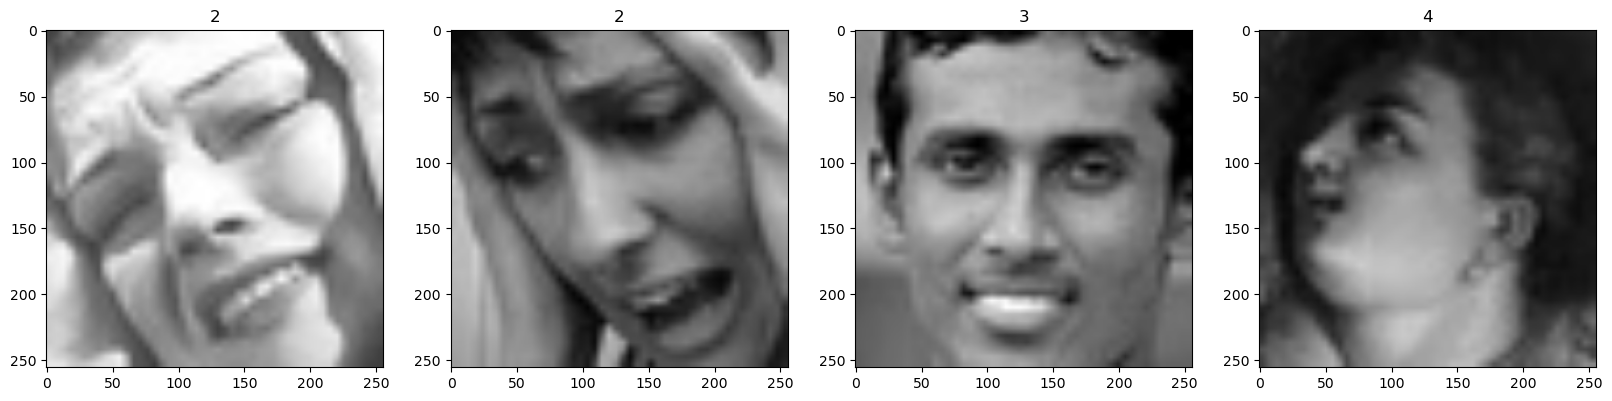

In [16]:
fig, ax = plt.subplots(ncols = 4, figsize = (20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# Split data

In [17]:
len(data)

901

In [18]:
train_size = int(len(data)*.07)
val_size = int(len(data)*.02)
test_size = int(len(data)*.01)

In [19]:
print(train_size)
print(val_size)
print(test_size)

63
18
9


In [20]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

In [21]:
print(len(train))
print(len(val))
print(len(test))

63
18
9


# Deep Model

## Build deep learning model

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten 

In [23]:
model = Sequential()

In [24]:
model.add(Conv2D(16, (3, 3), 1, activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())
          
model.add(Conv2D(16, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())
          
model.add(Flatten())
          
model.add(Dense(256, activation='relu'))
model.add(Dense(7, activation='softmax'))

In [25]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy']
    )

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

## Train

In [27]:
logdir = 'logs'

In [28]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [29]:
hist = model.fit(train,
                epochs = 20,
                validation_data = val,
                callbacks = [tensorboard_callback],
                verbose=1
                )

Epoch 1/20


/home/anurag/anaconda3/envs/tf/lib/python3.10/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


63/63 [==============================] - 685s 11s/step - loss: 17.6589 - accuracy: 0.2252 - val_loss: 1.7318 - val_accuracy: 0.3038
Epoch 2/20
63/63 [==============================] - 800s 13s/step - loss: 1.6933 - accuracy: 0.3641 - val_loss: 1.7344 - val_accuracy: 0.3385
Epoch 3/20
63/63 [==============================] - 844s 13s/step - loss: 1.3382 - accuracy: 0.5198 - val_loss: 1.6915 - val_accuracy: 0.3889
Epoch 4/20
63/63 [==============================] - 597s 10s/step - loss: 1.0001 - accuracy: 0.6577 - val_loss: 1.7434 - val_accuracy: 0.4375
Epoch 5/20
63/63 [==============================] - 641s 10s/step - loss: 0.6530 - accuracy: 0.7872 - val_loss: 1.8045 - val_accuracy: 0.4566
Epoch 6/20
63/63 [==============================] - 634s 10s/step - loss: 0.4388 - accuracy: 0.8601 - val_loss: 2.1831 - val_accuracy: 0.4722
Epoch 7/20
63/63 [==============================] - 640s 10s/step - loss: 0.3261 - accuracy: 0.9023 - val_loss: 2.4838 - val_accuracy: 0.5191
Epoch 8/20
63/63

In [ ]:
hist

In [ ]:
hist.history

## Plot Performance

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()